In [ ]:
import math
from model import *

solid_angle_scaling = math.sin(math.radians(5 / 2)) / math.sin(math.radians(60 / 2))
APER_0_D = 0.5
DET_D = 25

predictor1 = ElectronOpticsPredictor.load_model("outlier_predictor1")
predictor2 = ElectronOpticsPredictor.load_model("outlier_predictor2")
predictor3 = ElectronOpticsPredictor.load_model("outlier_predictor3")
predictor4 = ElectronOpticsPredictor.load_model("outlier_predictor4")


def angle_resolved_aper0(aper0_map: torch.Tensor) -> torch.Tensor:
    aberrations = (
        aper0_map[0] ** 2
        + aper0_map[2] ** 2
        + (aper0_map[3] * solid_angle_scaling) ** 2
        + (aper0_map[4] * (solid_angle_scaling**2)) ** 2
        + (aper0_map[5] * (solid_angle_scaling**3)) ** 2
    )
    return (
        aberrations
        + (torch.abs(aper0_map[1] * solid_angle_scaling) - APER_0_D / 2) ** 2
    )


def spatial_resolved_detector(detector_map: torch.Tensor) -> torch.Tensor:
    aberrations = (
        (detector_map[1] * solid_angle_scaling) ** 2
        + detector_map[2] ** 2
        + (detector_map[3] * solid_angle_scaling) ** 2
        + (detector_map[4] * (solid_angle_scaling**2)) ** 2
        + (detector_map[5] * (solid_angle_scaling**3)) ** 2
    )
    return aberrations + (torch.abs(detector_map[0]) - DET_D / 2) ** 2


def metric(output: torch.Tensor | np.ndarray):
    if isinstance(output, np.ndarray):
        if output.ndim == 1:
            output = torch.tensor(output)
        else:
            all_metrics = []
            for single_output in output:
                all_metrics.append(metric(single_output))
            return all_metrics
    return angle_resolved_aper0(output[:6]) * 1000 + spatial_resolved_detector(
        output[6:]
    )

Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu


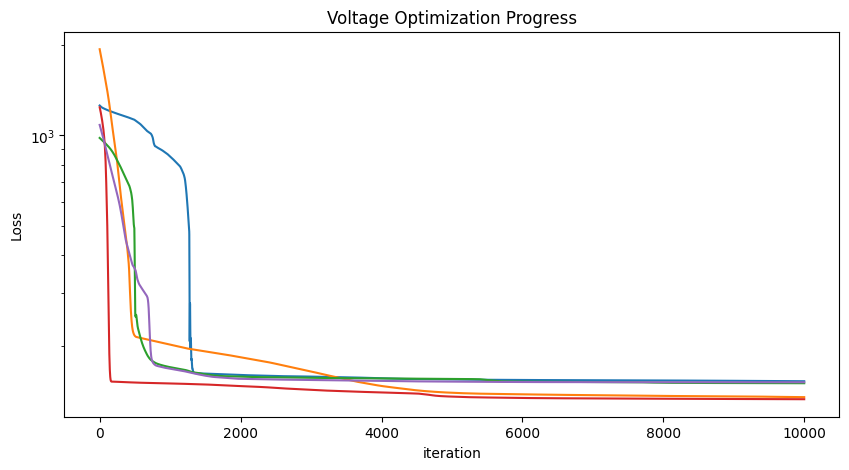

In [2]:
best_voltages, best_values, best_objective = optimize_voltages(
    [predictor1, predictor2, predictor3, predictor4],
    metric,
    n_iterations=10000,
    random_restarts=5,
)

In [3]:
print(best_voltages)
print(best_values)
print(best_objective)

[ 129.42366    136.46336    314.68378    194.67299     85.2585
 -125.75857     25.934492   191.43773    124.29594     -1.1001508
  419.5545      11.304367  -129.58952    244.84613  ]
tensor([ 3.5286e-05,  2.8641e+00,  1.4043e-03, -6.5636e-02, -9.3024e-01,
         3.5955e+01,  2.6220e-01,  7.2352e+00, -5.1788e-02, -4.2607e+00,
        -6.7008e+01, -1.5086e+03])
152.22097778320312


In [4]:
metric(torch.tensor([0, 0.25 / solid_angle_scaling, 0, 0, 0, 0, 12.5, 0, 0, 0, 0, 0]))

tensor(2.2204e-13)